In [1]:
import pennylane as qml
from itertools import combinations
import networkx as nx
import numpy as np
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

### Global variables

In [2]:
j=1
eps=1.0
g=1.0
V=1.0

v = 12#12 #initial state
n_qubits = 4*j

In [3]:
# Parameters for time evolution

t_max = 5.0            # Maximum evolution time
time_steps = 50        # Number of time intervals
n_trotter_steps = 15   # Number of Trotter steps
trotter_order = 1      # Trotter order

# Define the time intervals
times = np.linspace(0, t_max, time_steps)

## Encoding Method

In [4]:
# Encode indices with the specified rule
def encode_indices(p, m, j):
    if p not in {1, -1}:
        raise ValueError("p must be either 1 or -1.")
    if m == 0 or not (-j <= m <= j):
        raise ValueError(f"m must be in the range +/-1, +/-2, ..., +/-j, but got m={m} and j={j}.")

    if m > 0:
        k = j - m
    else:
        k = j - m - 1 # shift by one because m can't be 0

    if p == -1:
        k += 2 * j

    return k

# Decode a single index back into multi-indices (p, m, j)
def decode_index(k, j):
    if k < 0 or k >= 4 * j:
        raise ValueError(f"k={k} is out of valid range for j={j}.")

    # Determine p based on the range of k
    p = 1 if k < 2 * j else -1

    # Adjust k for p = -1
    k_adjusted = k if p == 1 else k - 2 * j

    # Determine m
    m = j - k_adjusted if k_adjusted < j else j - (k_adjusted + 1) # inverse of the encoding line in encode_indices

    return p, m

### Test Encoding

In [5]:

for p in [1, -1]:
    for m in range(j, -j-1, -1):
        if m == 0: continue

        k = encode_indices(p, m, j)
        p_, m_ = decode_index(k, j)

        print("Original indices: p={}, m={}".format(p, m, j))
        print("Decoded indices:  p={}, m={}".format(p_, m_))
        print("Encoded index:    k={}".format(k))
        print()

Original indices: p=1, m=1
Decoded indices:  p=1, m=1
Encoded index:    k=0

Original indices: p=1, m=-1
Decoded indices:  p=1, m=-1
Encoded index:    k=1

Original indices: p=-1, m=1
Decoded indices:  p=-1, m=1
Encoded index:    k=2

Original indices: p=-1, m=-1
Decoded indices:  p=-1, m=-1
Encoded index:    k=3



## Hamiltonian

In [6]:
# Annihilation operator
def C(p, m, j):
    return qml.FermiA(encode_indices(p, m, j))

# Creation operator
def C_dag(p, m, j):
    return qml.FermiC(encode_indices(p, m, j))

# Agassi Hamiltonian
def agassi_hamiltonian(j, eps, g, V):
    
    # J0 term
    J0 = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J0 += C_dag(1, m, j) * C(1, m, j) - C_dag(-1, m, j) * C(-1, m, j)
    J0 *= 0.5

    # J+ and J- term
    J_plus = 0
    J_minus = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J_plus  += C_dag(1, m, j) * C(-1, m, j)
        J_minus += C_dag(-1, m, j) * C(1, m, j)

    # A_i terms
    
    def A_dag(p, j):
        res = 0
        # unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        for m in range(0, j+1):
            if m == 0: continue
            res += C_dag(p, m, j) * C_dag(p, -m, j)
        return res
    
    def A(p, j):
        res = 0
        # unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        for m in range(0, j+1):
            if m == 0: continue
            res += C(p, -m, j) * C(p, m, j)
        return res

    A_terms = 0
    for p in [-1, 1]:
        for p_ in [-1, 1]:
            A_terms += A_dag(p, j) * A(p_, j)
    
    
    # Hamiltonian
    H = eps * J0 - g * A_terms - V/2 * (J_plus * J_plus + J_minus * J_minus)
    
    return H

H_sec = agassi_hamiltonian(j, eps, g, V)
print("Second quantization Hamiltonian:")
print(H_sec)
print()

H_ps = qml.jordan_wigner(H_sec, ps=True, wire_map={0: 0, 1: 1, 2: 2, 3: 3})
# H = H.simplify()
print("Jordan-Wigner Hamiltonian:")
print(H_ps)
print()


Second quantization Hamiltonian:
-1.0 * a⁺(2) a⁺(3) a(3) a(2)
+ -0.0 * a⁺(2) a⁺(3)
+ -0.0 * a(3) a(2)
+ 0.0 * I
+ -1.0 * a⁺(2) a⁺(3) a(1) a(0)
+ -0.0 * a(1) a(0)
+ -1.0 * a⁺(0) a⁺(1) a(3) a(2)
+ -0.0 * a⁺(0) a⁺(1)
+ -1.0 * a⁺(0) a⁺(1) a(1) a(0)
+ 0.5 * a⁺(0) a(0)
+ -0.5 * a⁺(2) a(2)
+ 0.5 * a⁺(1) a(1)
+ -0.5 * a⁺(3) a(3)
+ -0.5 * a⁺(0) a(2) a⁺(0) a(2)
+ 0.0 * a⁺(0) a(2)
+ -0.5 * a⁺(0) a(2) a⁺(1) a(3)
+ 0.0 * a⁺(1) a(3)
+ -0.5 * a⁺(1) a(3) a⁺(0) a(2)
+ -0.5 * a⁺(1) a(3) a⁺(1) a(3)
+ -0.5 * a⁺(2) a(0) a⁺(2) a(0)
+ 0.0 * a⁺(2) a(0)
+ -0.5 * a⁺(2) a(0) a⁺(3) a(1)
+ 0.0 * a⁺(3) a(1)
+ -0.5 * a⁺(3) a(1) a⁺(2) a(0)
+ -0.5 * a⁺(3) a(1) a⁺(3) a(1)

Jordan-Wigner Hamiltonian:
(-0.5+0j) * I
+ (0.5+0j) * Z(2)
+ (0.5+0j) * Z(3)
+ (-0.25+0j) * Z(2) @ Z(3)
+ (-0.25+0j) * Y(2) @ X(3) @ Y(0) @ X(1)
+ (-0.25+0j) * Y(2) @ X(3) @ X(0) @ Y(1)
+ (0.25+0j) * Y(2) @ Y(3) @ X(0) @ X(1)
+ (-0.25+0j) * Y(2) @ Y(3) @ Y(0) @ Y(1)
+ (-0.25+0j) * X(2) @ X(3) @ X(0) @ X(1)
+ (0.25+0j) * X(2) @ X(3) @ Y(0) @ Y(1)
+ (-

Split Hamiltonian for trotterization


## Determine hamiltonian components for trotterization

#### Add Implicit Terms to Hamiltonian

In [7]:
from copy import deepcopy

def add_implicit_terms(H1_raw, n_qubits):
    H_new = deepcopy(H1_raw)
    for i in range(0, n_qubits):
        w = qml.pauli.PauliWord({i:"Z"})
        if w not in H1_raw:
            H_new[w] = 0.0
    return H_new

#### Plot Cliquets

In [8]:
def draw_cliquet_decomposition(G_base, cliques):
     
    #plot graph with cliques

    import matplotlib.pyplot as plt
    import numpy as np

    # Define a list of colors for different cliques
    # colors = plt.cm.get_cmap("tab10", len(cliques))  # Get distinct colors
    # colors = plt.cm.get_cmap("Set1", len(cliques))  # "Set1" provides bright, distinct colors

    def generate_vibrant_colors(n_colors):
        """
        Generate a list of 'n_colors' distinct, vibrant colors while avoiding gray-like colors.
        """
        cmap = plt.cm.get_cmap("hsv", n_colors * 2)  # Use HSV colormap for high-saturation colors
        colors = [cmap(i) for i in range(n_colors * 2)]  # Get extra colors to filter

        # Keep only highly saturated colors (skip grays)
        vibrant_colors = [color for color in colors if np.mean(color[:3]) < 0.75]  # Avoid desaturated tones

        return vibrant_colors[:n_colors]  # Return only the needed number of colors

    # Example: Generate 15 vibrant colors with no grays
    num_cliques = len(cliques)  # Arbitrary dimension
    colors = generate_vibrant_colors(num_cliques)


    # Plot the original graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G_base)  # Position nodes

    # Draw the original graph in gray (background)
    # nx.draw(G_base, pos, edgelist=[], with_labels=True, node_color="red", edge_color="red", node_size=100, font_size=10)
    nx.draw(G_base, pos, with_labels=True, node_color="lightgray", edge_color="gray", node_size=50, font_size=10, alpha=0.2)


    # Draw each clique with a different color
    for i, clique in enumerate(cliques):
        nx.draw_networkx_nodes(G_base, pos, nodelist=clique, node_color=[colors[i]], node_size=200, alpha=0.5)
        nx.draw_networkx_edges(G_base, pos, edgelist=[(u, v) for u in clique for v in clique if G_base.has_edge(u, v)], edge_color=[colors[i]], width=2, alpha=0.5)

    plt.title("Original Graph with Highlighted Cliques")
    plt.show()

#### Get Cliquets

In [9]:
def get_hamiltonian_graph(H):
    H_list = list(zip(H_ps.keys(), H.values()))
    G = nx.Graph()
    G.add_nodes_from(H_list)

    # Compute commutators and add edges if they commute
    for i in range(len(H_list)):
        for k in range(i + 1, len(H_list)):
            a = H_list[i][0]
            b = H_list[k][0]
            if len(a.commutator(b)) == 0:  # Check commutation
                G.add_edge(H_list[i], H_list[k])
    return G


def get_clique_partitioning(G, cliques, verbose=False):

    iteration = 1
    while G.number_of_nodes() > 0:
        iter_node = nx.find_cliques(G)
        try:
            clique = next(iter_node)
        except StopIteration:
            break  # If no more cliques, exit loop

        if verbose:
            print(f"Iteration {iteration}: Removing clique {clique}")
        
        # Remove clique from graph
        cliques.append(clique)
        G.remove_nodes_from(clique)
        iteration += 1

    if verbose:
        print("Final graph (should be empty):", G.nodes())

    return cliques


def construct_hamiltonian_terms_from_cliques(cliques):
    H_terms = []
    for i in range(len(cliques)):
        H_term = qml.pauli.PauliSentence()
        for k in range(len(cliques[i])):
            H_term[cliques[i][k][0]] = cliques[i][k][1]
        H_terms.append(H_term)
    return H_terms

In [ ]:
# get best clique computing by computing trotter error
# At the moment this funciton finds different cliques partition starting from different initial maximal cliques

def get_best_clique_partitioning(G_base, num_iter=10, trotter_order=1, verbose=False):
    best_cliques = None
    best_err = np.inf
    order=list(range(0,n_qubits))
    
    first_cliques = list(nx.find_cliques(G_base))

    def commutator_list(list1, list2):
        commutators = []
        for i in range(len(list1)):
            for j in range(len(list2)):
                comm = qml.commutator(list1[i], list2[j], pauli=True)
                commutators.append(comm)
        return commutators

    for first_clique in first_cliques:
        
        G = G_base.copy()
        G.remove_nodes_from(first_clique)
        cliques = [first_clique]
        cliques = get_clique_partitioning(G, cliques, verbose=verbose)
        commutators = []


        H_terms = construct_hamiltonian_terms_from_cliques(cliques)
        
        
        err = 0#linalg.norm(x, ord=None, axis=None, keepdims=False)
        min_len = np.inf
        

        for i in range(len(H_terms)):
            clique_len = len(cliques[i])
            if clique_len < min_len:
                min_len = clique_len
            for j in range(1, len(H_terms)):
                first_commutator =qml.commutator(H_terms[i], H_terms[j], pauli=True)
                commutators.append(first_commutator)

        for p in range(1,trotter_order):

            commutators=commutator_list(H_terms, commutators)
    
            
        for comm in commutators:
            err += np.max(np.abs(np.linalg.eigvalsh(-1j * qml.matrix(comm, wire_order=order))))
            # err += np.linalg.norm(qml.matrix(comm, wire_order=order), ord=2)


        print(min_len, len(H_terms), err)

        # comm = ...
        if err < best_err:
            best_err = err
            best_cliques = cliques

        
    print("Best error:", best_err)
    return best_cliques

In [11]:
G = get_hamiltonian_graph(H_ps)
G_base = G.copy()
# cliques = get_clique_partitioning(G, verbose=True)
# H_terms = construct_hamiltonian_terms_from_cliques(cliques)

cliques = get_best_clique_partitioning(G, num_iter=10, verbose=False)
H_terms = construct_hamiltonian_terms_from_cliques(cliques)
print("number of terms in hamiltonian:", len(H_terms))


5 2 4.0
2 2 4.0
Best error: 4.0
number of terms in hamiltonian: 2


/var/folders/z4/q3_z78fj4gldz7hpcmkdj1y00000gn/T/ipykernel_3867/930723683.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("hsv", n_colors * 2)  # Use HSV colormap for high-saturation colors


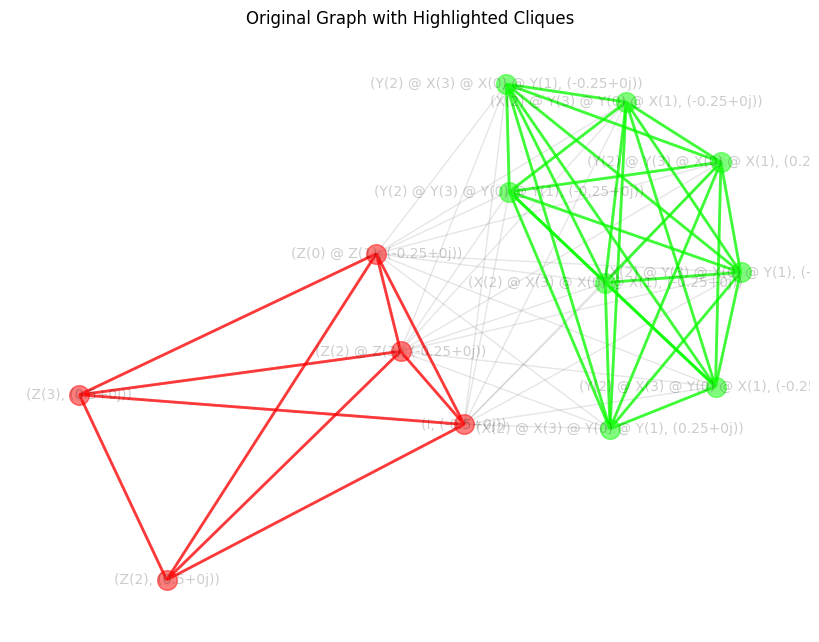

In [12]:
draw_cliquet_decomposition(G_base, cliques)

## Automatically Calculate Commutators

In [13]:
#calculate commutators of terms in H

def test_commutativity(H):
    
    split_sentences1 = {}

    for pauli_word, value in H.items():
        # If this number is not already in the dictionary, initialize a new PauliSentence
        if pauli_word not in split_sentences1:
            split_sentences1[pauli_word] = qml.pauli.PauliSentence()

    # Iterate over all pairs of PauliSentences from split_sentences2 and test commutativity
    for (key1, ps1), (key2, ps2) in combinations(split_sentences1.items(), 2):
        # Compute their commutator
        comm = qml.commutator(key1,key2, pauli=True)
        

        # Check if they commute
        if np.allclose(comm.operation().matrix(), 0):
            # print(f"{key1} and {key2} commute.")
            # print("COMMUTE")
            pass
        else:
            print("DO NOT COMMUTE")
            # print(f"{key1} and {key2} do NOT commute.")

In [14]:
for i in range(len(H_terms)):
    test_commutativity(H_terms[i])

In [15]:
#test commutation between different split of hamiltonian

import pennylane as qml

def test_commutativity_between_split(H_terms):
    """Check commutativity of all pairs in the given list of Pauli words."""
    num_terms = len(H_terms)
    commutation_results = {}

    for i in range(num_terms):
        for j in range(i + 1, num_terms):  # Check only unique pairs (i, j)
            ps1 = H_terms[i]
            ps2 = H_terms[j]
            
            # Compute the commutator using PennyLane
            comm = ps1.commutator(ps2)

            # Check if the commutator is empty (i.e., they commute)
            is_commuting = len(comm) == 0
            commutation_results[(i, j)] = is_commuting

            print(f"Commutator of term {i} and term {j}: {'Commute' if is_commuting else 'Do not commute'}")
            print(comm)

    return commutation_results

commutation_results = test_commutativity_between_split(H_terms)

Commutator of term 0 and term 1: Do not commute
-0.5j * Y(2) @ Y(3) @ X(0) @ Y(1)
+ 0.5j * Y(2) @ X(3) @ Y(0) @ Y(1)
+ -0.5j * Y(2) @ X(3) @ X(0) @ X(1)
+ -0.5j * X(2) @ Y(3) @ X(0) @ X(1)
+ 0.5j * X(2) @ Y(3) @ Y(0) @ Y(1)
+ 0.5j * X(2) @ X(3) @ Y(0) @ X(1)
+ -0.5j * Y(2) @ Y(3) @ Y(0) @ X(1)
+ 0.5j * X(2) @ X(3) @ X(0) @ Y(1)


In [16]:

# from itertools import combinations
# from pennylane.pauli import PauliSentence

# # Iterate over all pairs of PauliSentences from split_result and test commutativity
# for (num_ops1, ps1), (num_ops2, ps2) in combinations(split_result.items(), 2):
#     # Compute their commutator
#     comm = ps1.commutator(ps2)

#     # Check if they commute
#     if len(comm) == 0:
#         print(f"Pauli sentences with {num_ops1} and {num_ops2} operators commute.")
#     else:
#         print(f"Pauli sentences with {num_ops1} and {num_ops2} operators do NOT commute.")

## Time Evolution functions

### create initial state

In [17]:

# Initial state

dim = 2**n_qubits
initial_state = np.zeros(dim, dtype=complex)
initial_state[v] = 1

print(initial_state.shape)
print(n_qubits)

(16,)
4


### get matrix form of hamiltonian terms

In [18]:
#get matrix form of all the hamiltonians

order = list(range(n_qubits))

for i in range(0,n_qubits):
    order[i]=i

H = qml.matrix(H_ps, wire_order=order)

# H = get_matrix_from_ps(H_ps)

H_terms_implicit = []
for term in H_terms:
    H_terms_implicit.append(add_implicit_terms(term, n_qubits))

H_terms_mat = []
for term in H_terms_implicit:
    # H_terms_mat.append(term.operation().matrix())
    H_terms_mat.append(qml.matrix(term, wire_order=order))





### define evolution and correlation function

In [19]:


def paper_evo(t, n, trotter_order=1):

    if trotter_order == 1: 
        U = np.identity(H.shape[0])
        for _ in range(0, n):
            for term in H_terms_mat:
                U = U @ expm(-1j * term * (t/n))
        
        evolved_state = U @ initial_state
        return evolved_state
        
    else:

        if trotter_order%2 == 1: raise ValueError("Trotter order must be even or 1.")

        # order 2
        def trotter_block(k, t, n):

            U = np.identity(H.shape[0])
            if k == 1:
                for i in range(len(H_terms_mat)-1):
                    term = H_terms_mat[i]
                    # print(i)
                    U = U @ expm(-0.5j * term * (t/n))

                U = U @ expm(-1j * H_terms_mat[-1] * (t/n))

                for i in range(len((H_terms_mat))-2, -1, -1):
                    term = H_terms_mat[i]
                    # print(i)
                    U = U @ expm(-0.5j * term * (t/n))
                
                return U
            
            else:
                u_k = 1/(4-4**(1/(2*k-1)))
                a = trotter_block(k-1, u_k * t, n)
                b = a @ a
                c = trotter_block(k-1, (1 - 4*u_k) * t, n)
                U = b @ c @ b
                return U

        U = np.identity(H.shape[0])
        block = trotter_block(trotter_order/2, t, n)
        for _ in range(n):
            U = U @ block
        
        return U @ initial_state

# exact time evolution
def exact_evo(t):
    U = np.identity(H.shape[0])
    U = U @ expm(-1j * H * (t)) 
    evolved_state = U @ initial_state
    return evolved_state


In [20]:
#compute correlation function
def correlation_function (i, j, evo):
    Zi_raw = qml.pauli.PauliWord({i:"Z"})
    Zj_raw = qml.pauli.PauliWord({j:"Z"})
    psi = qml.pauli.PauliSentence()
    psi[Zi_raw]= 1.0
    psj = qml.pauli.PauliSentence()
    psj[Zj_raw]= 1.0

    Zi=add_implicit_terms(psi, n_qubits).operation().matrix()
    Zj=add_implicit_terms(psj, n_qubits).operation().matrix()

    evo=paper_evo(t, n_trotter_steps, trotter_order=trotter_order)
    
    sigma_ij_trotter=np.vdot(evo,Zi @ Zj @ evo)-np.vdot(evo ,Zi @ evo)*np.vdot(evo,Zj @ evo)

    return sigma_ij_trotter

## Compute evolution 

### Paper Evolution

In [21]:
overlaps_paper_evo = []
correlations_trotter = []
states_paper_evo = []

# Compute the overlap with initial state
for t in times:
    result = paper_evo(t, n_trotter_steps, trotter_order=trotter_order)
    states_paper_evo.append(result)

    overlap = np.vdot(initial_state, result)
    overlap = np.abs(overlap)**2
    overlaps_paper_evo.append(overlap)

    # Compute the correlation function for trotterized evolution
    correlation_trotter = correlation_function(0, 1, result)
    correlations_trotter.append(correlation_trotter)
    




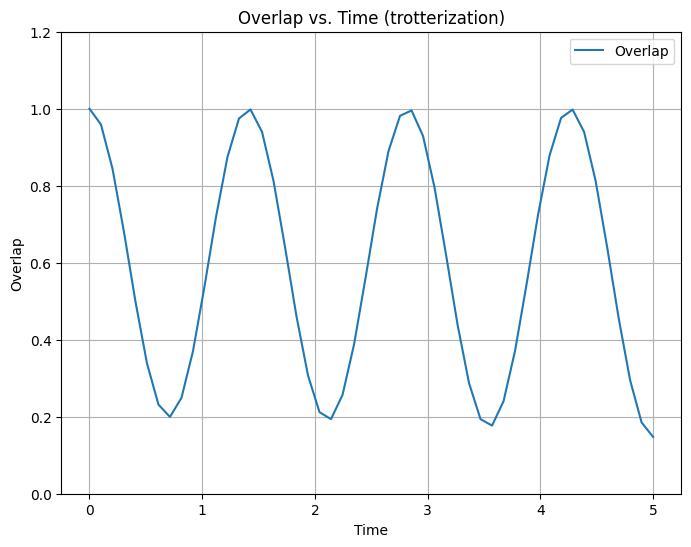

Final overlap: 0.14753801783240242


In [22]:


# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(times, overlaps_paper_evo, label="Overlap")
plt.xlabel("Time")
plt.ylabel("Overlap")
plt.ylim([0, 1.2])
plt.title("Overlap vs. Time (trotterization)")
plt.grid()
plt.legend()
plt.show()

print("Final overlap:", overlaps_paper_evo[-1])



### Exact Evolution

In [23]:

overlaps_exact_evo = []
correlations_exact = []
states_exact_evo = []

# Compute the overlap with initial state
for t in times:
    result = exact_evo(t)
    states_exact_evo.append(result)
    #result = result.numpy()  # Convert to NumPy array if required
    
    overlap = np.vdot(initial_state, result) 
    overlap = np.abs(overlap)**2
    overlaps_exact_evo.append(overlap)

    correlation_exact = correlation_function(0, 1, result)
    correlations_exact.append(correlation_exact)


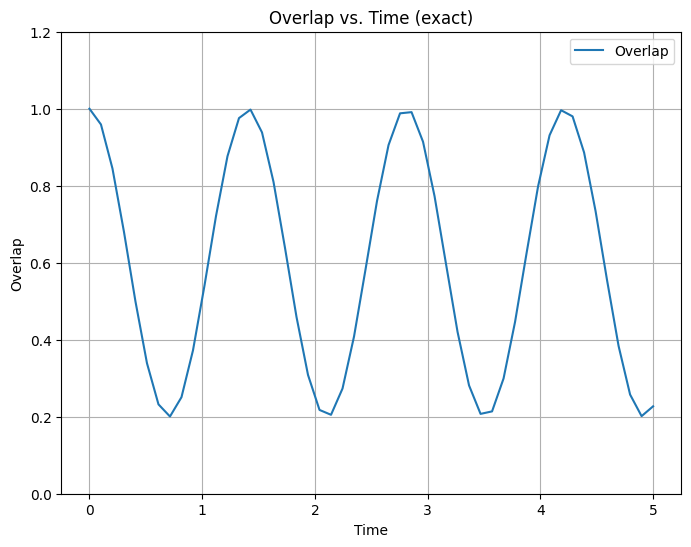

In [24]:

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(times, overlaps_exact_evo, label="Overlap")
plt.xlabel("Time")
plt.ylabel("Overlap")
plt.ylim([0, 1.2])
plt.title("Overlap vs. Time (exact)")
plt.grid()
plt.legend()
plt.show()



### Error

In [25]:
probabilities = []

# compute overlap between exact and paper evolution
for i in range(times.shape[0]):
    # evolved_state_exact = exact_evo(t)
    # evolved_state_trotter = paper_evo(t, n_trotter_steps, trotter_order=trotter_order)  # Execute the circuit
    # evolved_state_trotter = paper_evo_higher_order2(t, n_trotter_steps)  # Execute the circuit
    # evolved_state_trotter = evolved_state_trotter.numpy()  # uncomment when using pennylane_evo
    
    # overlap = np.vdot(evolved_state_exact, evolved_state_trotter)
    overlap = np.vdot(states_exact_evo[i], states_paper_evo[i])
    probability = np.abs(overlap)**2
    probabilities.append(probability)

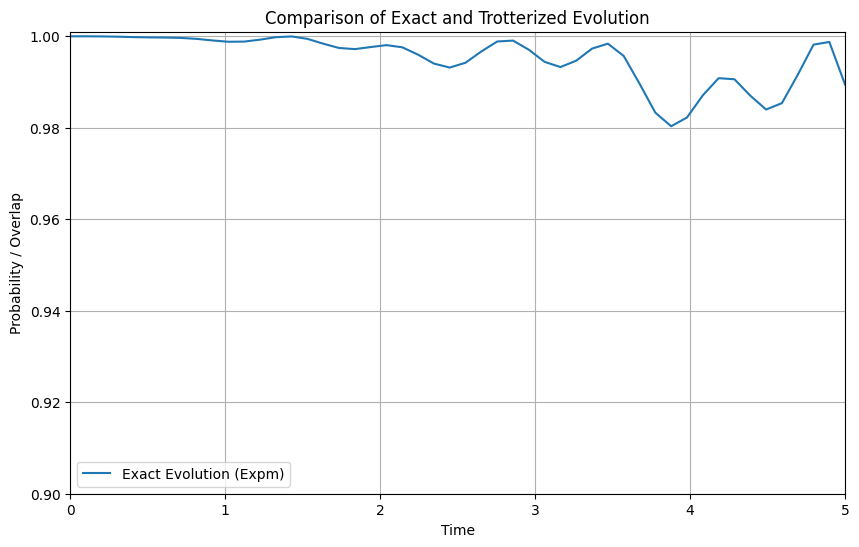

In [26]:
# Plot both results
plt.figure(figsize=(10, 6))
plt.plot(times, probabilities, label="Exact Evolution (Expm)", markersize=3)
plt.xlabel("Time")
plt.ylabel("Probability / Overlap")
plt.xlim([0, t_max])
plt.ylim([0.90, 1.001])
plt.title("Comparison of Exact and Trotterized Evolution")
plt.grid()
plt.legend()
plt.show()

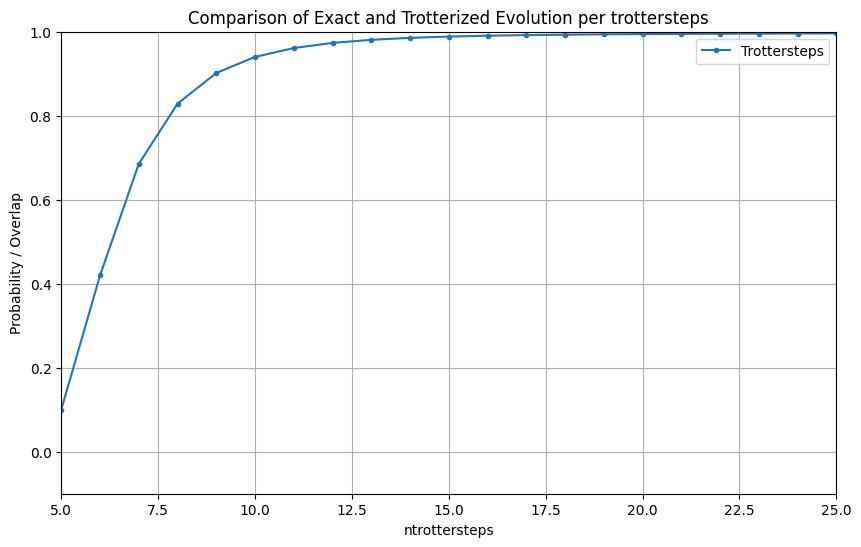

In [27]:
#comparison per number of trotter steps at given time

probabilities1 = []

min_trotter_step = 5
max_trotter_step = 25
trotter_steps = np.arange(min_trotter_step, max_trotter_step + 1)

# compute overlap between exact and paper evolution
for n in trotter_steps:
    evolved_state_exact = exact_evo(5)
    evolved_state_trotter = paper_evo(5, n, trotter_order=trotter_order)  # Execute the circuit
    # evolved_state_trotter = paper_evo_higher_order(5, n)  # Execute the circuit
    # evolved_state_trotter = evolved_state_trotter.numpy()  # uncomment when using pennylane_evo
    
    overlap = np.vdot(evolved_state_exact, evolved_state_trotter)
    probability = np.abs(overlap)**2
    probabilities1.append(probability)

# Plot both results
plt.figure(figsize=(10, 6))
plt.plot(trotter_steps, probabilities1, label="Trottersteps", marker="o", markersize=3)
plt.xlabel("ntrottersteps")
plt.ylabel("Probability / Overlap")
plt.xlim([min_trotter_step, max_trotter_step])
plt.ylim([-0.1, 1.001])
plt.title("Comparison of Exact and Trotterized Evolution per trottersteps")
plt.grid()
plt.legend()
plt.show()


/Users/massimodicosimo/miniconda3/envs/qctrieste24/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/massimodicosimo/miniconda3/envs/qctrieste24/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/massimodicosimo/miniconda3/envs/qctrieste24/lib/python3.10/site-packages/matplotlib/collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


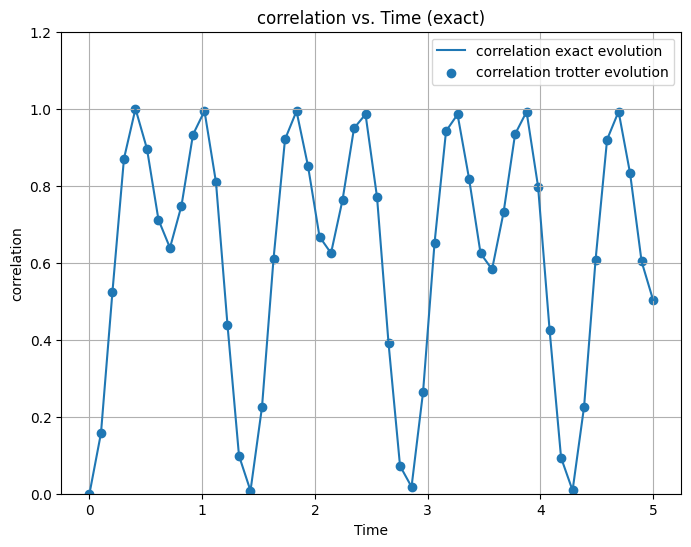

In [28]:
# Plot correlations

plt.figure(figsize=(8, 6))
plt.plot(times, correlations_exact, label="correlation exact evolution")
plt.scatter(times, correlations_trotter, label="correlation trotter evolution")
plt.xlabel("Time")
plt.ylabel("correlation")
plt.ylim([0, 1.2])
plt.title("correlation vs. Time (exact)")
plt.grid()
plt.legend()
plt.show()



## Extra

In [29]:


# dev = qml.device("default.qubit", wires=int(np.log2(H.shape[0])))
# @qml.qnode(dev)

# def pennylane_evo(t, n, v):
#     b=int(np.log2(H.shape[0]))
#     for i in range (0, b):
#         if v >= (2**(b-i-1)):
#             qml.PauliX(wires=(i))
#             v=v-2**(b-i-1)
#         # print(v)
#     qml.ApproxTimeEvolution(H_ps.hamiltonian(), t, n)
#     return qml.state()


### Check which initial states evolve

In [30]:
#checks for every inital state which one evolves

dim = 2**n_qubits
def get_initial_state(v):
    initial_state = np.zeros(dim, dtype=complex)
    initial_state[v] = 1
    return initial_state

print(initial_state.shape)

def exact_evo_all(t, v, H):
    initial_state=get_initial_state(v)
    U = np.identity(H.shape[0])
    U = U @ expm(-1j * H * (t)) 
    evolved_state = U @ initial_state
    overlap=np.abs(np.vdot(evolved_state, initial_state))**2
    return overlap

for v in range(0,2**n_qubits):
    print(v, exact_evo_all(5, v, H))

(16,)
0 1.0
1 0.9999999999999996
2 0.9999999999999996
3 0.22700129259554902
4 0.9999999999999996
5 1.0
6 1.0
7 1.0000000000000004
8 0.9999999999999996
9 1.0
10 1.0
11 1.0000000000000004
12 0.22700129259554871
13 0.9999999999999996
14 0.9999999999999996
15 0.9999999999999996
